## This Notebook is a first part of Research to DFDC


Advanced knowledge in probability theory, numerical methods will not give you much boost in your prediction ;)

Since I have a weak computer with only 8 GB of RAM and don't have a GPU, also Kaggle limits me to 30 hours of weekly use, I don’t have much opportunity to create a good predictor that can learn 500 GB of data :)).

And so I decided to do the approximation of the outputs to real labels, and here is what came of it:

I was able to squeeze 0.41423 from the ensemble of two architectures ResNext and XCeption

In [1]:
import os

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)

from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
%matplotlib inline

In [2]:
TestVideosDirectory = "test_videos/"

TestVideos = sorted([x for x in os.listdir(TestVideosDirectory) if x[-4:] == ".mp4"])

Metadata = pd.read_csv('data/metadata')

Metadata

,filename,video.@index,video.@codec_time_base,video.@width,video.@height,video.@sample_aspect_ratio,video.@display_aspect_ratio,video.@level,video.@r_frame_rate,video.@time_base,video.@duration_ts,video.@duration,video.@bit_rate,video.@nb_frames,audio.@index,audio.@codec_name,audio.@codec_long_name,audio.@codec_time_base,audio.@duration_ts,audio.@duration,audio.@bit_rate,audio.@max_bit_rate,audio.@nb_frames,label,split,original,folder,wav.hash.cnt,original.cnt,md5,md5.orig,wav.hash,wav.hash.orig,pxl.hash,pxl.hash.orig
0,hrundztjfb.mp4,0,2500/150301,1920,1080,1:1,16:9,40,150301/5000,1/150301,1505000,10.013240,6313271,301,1,aac,AAC (Advanced Audio Coding),1/48000,480000,10,69272,69272,470,FAKE,train,vvrlglaepq.mp4,dfdc_train_part_12,3.0,2.0,7b1db59bdb78179aa3ed78a4270ed063,d98cd8af0ba7ce2a51acefb2c0502b71,6877743394119074431s,6877743394119074431s,4312499372455908935s,16061268809469102567s
1,uyfnfvsxez.mp4,0,50/2997,1920,1080,NAN,NAN,40,2997/100,1/11988,120000,10.010010,5381739,300,1,aac,AAC (Advanced Audio Coding),1/48000,480000,10,69300,69300,470,REAL,train,NAN,dfdc_train_part_12,2.0,NaN,62c47bd354599ce0fad65d28ef4b78b9,NaN,-4734951634879773329s,NaN,17835547769154037975s,NaN
2,yknlciphae.mp4,0,50/2997,1920,1080,1:1,16:9,40,2997/100,1/11988,120000,10.010010,3084315,300,1,aac,AAC (Advanced Audio Coding),1/48000,480000,10,69328,69328,470,FAKE,train,ahesnzswur.mp4,dfdc_train_part_12,6.0,5.0,a0e4d1f8bf2636def22dc2f2b21187dd,3bb70580dbf21c4719f17c4e4617c398,-5599986156292069640s,-5599986156292069640s,16356267960363338360s,14219253130038039922s
3,zfyczzssiz.mp4,0,50/2997,1920,1080,1:1,16:9,40,2997/100,1/11988,120000,10.010010,2676702,300,1,aac,AAC (Advanced Audio Coding),1/48000,480000,10,69304,69304,470,FAKE,train,jdvzqjihud.mp4,dfdc_train_part_12,7.0,6.0,d641ebd07badeb89c0d389019d9f7e72,c77170df2cc8b40ef1d39b6d79105321,-1564427678199738496s,-1564427678199738496s,12983824148373679782s,6108291220829004959s
4,kggbciadwj.mp4,0,125/7501,1080,1920,1:1,9:16,40,7501/250,1/15002,150500,10.031996,2380394,301,1,aac,AAC (Advanced Audio Coding),1/48000,480000,10,69229,69229,470,REAL,train,NAN,dfdc_train_part_12,9.0,NaN,7de3ddacab0c9109e2a985d2c03244ea,NaN,-1251615899500302547s,NaN,970391495631676767s,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119141,ecqiuhmijo.mp4,0,625/37599,1920,1080,1:1,16:9,40,37599/1250,1/37599,376250,10.006915,4260186,301,1,aac,AAC (Advanced Audio Coding),1/48000,480000,10.000000,69266,69266,470,FAKE,train,qgalcgvqoz.mp4,dfdc_train_part_8,13.0,12.0,cec335ee37f9cfc703754ff8cffe08d0,48b61cbb5e78bcfb8d2a0f2114442b35,8884601750571192987s,8884601750571192987s,1707335066847917120s,12896116552346240566s
119142,bfifbfziqw.mp4,0,5000/298729,1920,1080,1:1,16:9,40,298729/10000,1/298729,2990000,10.009072,4326686,299,1,aac,AAC (Advanced Audio Coding),1/48000,480000,10.000000,69365,69365,470,FAKE,train,sbfqskzcxw.mp4,dfdc_train_part_8,18.0,17.0,78a424879ac99067468ad067499d5614,a62cba493cf1d13d780e3b3f90934bbb,1261302301170646961s,1261302301170646961s,3973207955448026452s,5361291702580585497s
119143,hwzqeodegs.mp4,0,50/2997,1920,1080,NAN,NAN,40,2997/100,1/11988,120000,10.010010,3040474,300,1,aac,AAC (Advanced Audio Coding),1/48000,480000,10.000000,69292,69292,470,REAL,train,NAN,dfdc_train_part_8,2.0,NaN,9d2099f4415aa24a0b1af0260dfd7008,NaN,-6344801452981133525s,NaN,5143388631801766485s,NaN
119144,cbukvshrzm.mp4,0,5000/298731,1920,1080,1:1,16:9,40,298731/10000,1/298731,2990000,10.009005,3537043,299,1,aac,AAC (Advanced Audio Coding),1/48000,480000,10.000000,69313,69313,470,FAKE,train,gbbkbmzpfl.mp4,dfdc_train_part_8,9.0,13.0,f3ac2c37197486057f4e056040b38931,fa18f60fac081166eb75b203ea44e0ab,1134449075896085660s,-2121756635260252783s,12898255773587192080s,14915045442117171048s


In [3]:
TestVideoFilter = Metadata.filename.isin(TestVideos)

TestData = Metadata[TestVideoFilter]

TestData.sort_values(by = 'filename', inplace = True)

TestData.reset_index(drop = True, inplace = True)

TestData

,filename,video.@index,video.@codec_time_base,video.@width,video.@height,video.@sample_aspect_ratio,video.@display_aspect_ratio,video.@level,video.@r_frame_rate,video.@time_base,video.@duration_ts,video.@duration,video.@bit_rate,video.@nb_frames,audio.@index,audio.@codec_name,audio.@codec_long_name,audio.@codec_time_base,audio.@duration_ts,audio.@duration,audio.@bit_rate,audio.@max_bit_rate,audio.@nb_frames,label,split,original,folder,wav.hash.cnt,original.cnt,md5,md5.orig,wav.hash,wav.hash.orig,pxl.hash,pxl.hash.orig
0,aassnaulhq.mp4,0,5000/298799,1920,1080,1:1,16:9,40,298799/10000,1/298799,2990000,10.006727,5506817,299,1,aac,AAC (Advanced Audio Coding),1/48000,480000,10.000000,69280,69280,470,FAKE,test,zlxfqidduw.mp4,dfdc_train_part_1,26.0,25.0,38c2a5f0d6af6e6973ac5559560d4593,4c096ce211549cf0441e46727734e723,-7002801714356441557s,-7002801714356441557s,5476728375508883834s,7550902114937588449s
1,aayfryxljh.mp4,0,5000/299687,1920,1080,NAN,NAN,40,299687/10000,1/299687,3000000,10.010444,8003636,300,1,aac,AAC (Advanced Audio Coding),1/44100,441000,10.000000,69320,69320,432,REAL,test,NAN,dfdc_train_part_2,7.0,NaN,133d8e29078c56c60de9b050b98806e2,NaN,-553662431922973638s,NaN,8704810190244714592s,NaN
2,acazlolrpz.mp4,0,5000/299689,1920,1080,1:1,16:9,40,299689/10000,1/299689,3000000,10.010377,3196149,300,1,aac,AAC (Advanced Audio Coding),1/44100,441000,10.000000,69302,69302,432,FAKE,test,fzmnxvmtgh.mp4,dfdc_train_part_2,25.0,24.0,a3744c1bdde0034c4f87c580f7c357d0,afbacbee4664ee57f5426aafd0f6462a,-8600993947997645547s,-8600993947997645547s,4753486508042413542s,7092175881937445492s
3,adohdulfwb.mp4,0,50/2997,1920,1080,NAN,NAN,40,2997/100,1/11988,120000,10.010010,2906986,300,1,aac,AAC (Advanced Audio Coding),1/48000,480000,10.000000,69368,69368,470,REAL,test,NAN,dfdc_train_part_2,2.0,NaN,d5940d7e2699c587a104748d402f4d06,NaN,8940707558690363081s,NaN,16056371487116158652s,NaN
4,ahjnxtiamx.mp4,0,1000/59937,1920,1080,1:1,16:9,40,59937/2000,1/59937,600000,10.010511,3325025,300,1,aac,AAC (Advanced Audio Coding),1/44100,441000,10.000000,69410,69410,432,FAKE,test,sznkemeqro.mp4,dfdc_train_part_2,17.0,16.0,36efc1272154f60e00705e6e35065c2c,529fd569a067d8fe50a514a8a34213c7,-6156802673959672388s,-6156802673959672388s,17697907832717829213s,3524288035767006092s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,ztyvglkcsf.mp4,0,2500/149843,1920,1080,NAN,NAN,40,149843/5000,1/149843,1500000,10.010478,2536224,300,1,aac,AAC (Advanced Audio Coding),1/44100,441000,10.000000,69298,69298,432,REAL,test,NAN,dfdc_train_part_2,1.0,NaN,091b533bf9915032adfea7a4a99f5ef7,NaN,-6518847674502972678s,NaN,6857706407832848649s,NaN
396,zuwwbbusgl.mp4,0,50/2997,1920,1080,NAN,NAN,40,2997/100,1/11988,120000,10.010010,2492150,300,1,aac,AAC (Advanced Audio Coding),1/48000,480000,10.000000,69374,69374,470,REAL,test,NAN,dfdc_train_part_2,2.0,NaN,657334f200553dda29600ffd64d5a68c,NaN,2720247462730225662s,NaN,3746478034237613036s,NaN
397,zxacihctqp.mp4,0,50/2997,1920,1080,NAN,NAN,40,2997/100,1/11988,120000,10.010010,3630708,300,1,aac,AAC (Advanced Audio Coding),1/48000,480000,10.000000,69265,69265,470,REAL,test,NAN,dfdc_train_part_2,2.0,NaN,1e2c17813ea7a03457ba0acf567ccb84,NaN,-3829252675762708200s,NaN,15950851350625096837s,NaN
398,zyufpqvpyu.mp4,0,5000/299689,1920,1080,1:1,16:9,40,299689/10000,1/299689,3000000,10.010377,3943752,300,1,aac,AAC (Advanced Audio Coding),1/44100,441000,10.000000,69276,69276,432,FAKE,test,ajiyrjfyzp.mp4,dfdc_train_part_2,34.0,33.0,78411fc787fbb55dc3df4567a8503b0a,db12958628382491e1ac40cf05179908,-3251472907873228332s,-3251472907873228332s,15475682082542757599s,6852821126405614008s


In [4]:
Submission = pd.read_csv('data/submission-4.csv')

Submission046 = pd.read_csv('data/sub0467x.csv')

Submission['rlabel'] = TestData.label

Submission.rlabel = Submission.rlabel.map({'FAKE': 1, 'REAL': 0})

Submission.info()

print(log_loss(Submission.rlabel, Submission.label))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
filename    400 non-null object
label       400 non-null float64
rlabel      400 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 9.5+ KB
0.32094612465362377


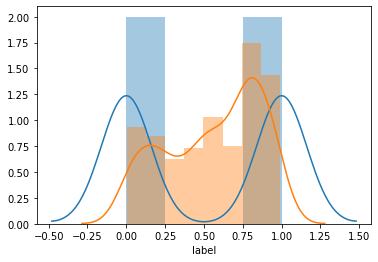

In [5]:
sns.distplot(Submission.rlabel)

sns.distplot(Submission.label)

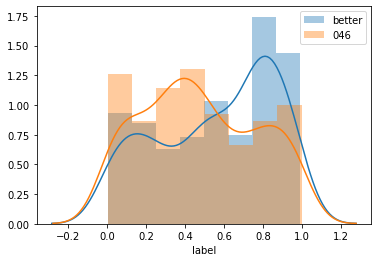

In [6]:
sns.distplot(Submission.label)

sns.distplot(Submission046.label)

plt.legend(labels = ['better','046'])

## Logistic Regression

Just her coefs gave boost

In [7]:
from sklearn.linear_model import LogisticRegression as LR

SubmissionWithCalibration = Submission.copy()

x = np.array(Submission.label)

lr = LR(penalty = 'l2', dual = True, tol = 0.0001, C = 1.3, fit_intercept = True, intercept_scaling = 1.0, 
        
        class_weight = None, random_state = None)     

lr.fit(x.reshape(-1, 1), Submission.rlabel)   

p_calibrated = lr.predict_proba(x.reshape(-1, 1))[:,1]

print(lr.coef_)

print(lr.intercept_)

print(log_loss(SubmissionWithCalibration.rlabel, p_calibrated))

[[7.72563273]]
[-4.50057079]
0.23373397068268567


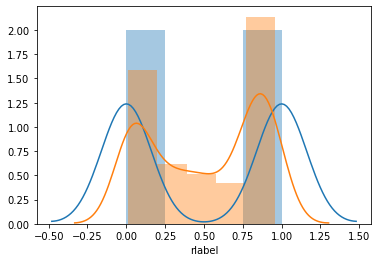

In [8]:
sns.distplot(Submission.rlabel)

sns.distplot(p_calibrated)

# Isotonic Regression

Waste of time

In [9]:
from sklearn.isotonic import IsotonicRegression as IR

ir = IR() # out_of_bounds = 'clip'

ir.fit(Submission.label, Submission.rlabel)

IRp_calibrated = ir.transform(Submission.label)

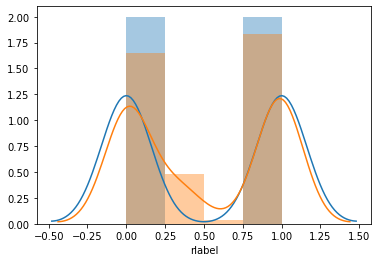

In [10]:
sns.distplot(Submission.rlabel)

sns.distplot(IRp_calibrated)

# Gradient Boosting Trees

In [11]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators = 300)

xgb.fit(x.reshape(-1, 1), Submission.rlabel)

XGBCalibrated = xgb.predict_proba(x.reshape(-1, 1))[:,1]

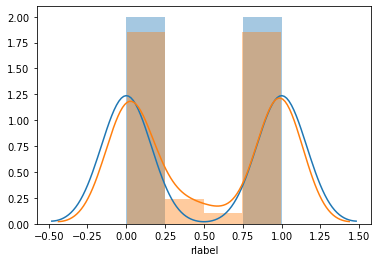

In [12]:
sns.distplot(Submission.rlabel)

sns.distplot(XGBCalibrated)

In [13]:
SubmissionWithCalibration['IRCalibration'] = IRp_calibrated

SubmissionWithCalibration['LRCalibration'] = p_calibrated

SubmissionWithCalibration['XGBCalibration'] =  XGBCalibrated

SubmissionWithCalibration

,filename,label,rlabel,IRCalibration,LRCalibration,XGBCalibration
0,aassnaulhq.mp4,0.799475,1,0.985714,0.842358,0.989672
1,aayfryxljh.mp4,0.063952,0,0.000000,0.017872,0.004667
2,acazlolrpz.mp4,0.802140,1,0.985714,0.845073,0.989672
3,adohdulfwb.mp4,0.048460,0,0.000000,0.015888,0.004667
4,ahjnxtiamx.mp4,0.821182,1,1.000000,0.863371,0.992015
...,...,...,...,...,...,...
395,ztyvglkcsf.mp4,0.118756,0,0.000000,0.027038,0.004667
396,zuwwbbusgl.mp4,0.068525,0,0.000000,0.018502,0.004667
397,zxacihctqp.mp4,0.297159,0,0.000000,0.099318,0.004667
398,zyufpqvpyu.mp4,0.778536,1,0.985714,0.819669,0.993303


In [14]:
print("Best submission on kaggle ", log_loss(SubmissionWithCalibration.rlabel, SubmissionWithCalibration.label))

print("Isotonic Regression calibration", log_loss(SubmissionWithCalibration.rlabel, SubmissionWithCalibration.IRCalibration))

print("Logistic Regression calibration", log_loss(SubmissionWithCalibration.rlabel, SubmissionWithCalibration.LRCalibration))

print("XGBoost calibration", log_loss(SubmissionWithCalibration.rlabel, SubmissionWithCalibration.XGBCalibration))

Best submission on kaggle  0.32094612465362377
Isotonic Regression calibration 0.1302618142978781
Logistic Regression calibration 0.23373397068268567
XGBoost calibration 0.09556986478972249
